In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.metrics import classification_report
import seaborn as sns
import re
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from scipy.sparse import csr_matrix
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score
from textblob import TextBlob
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
import torch
from torch.utils.data import Dataset 
from torch.utils.data import DataLoader
import gensim
from gensim.models import Word2Vec

### Загрузка и анализ данных, первичная предобработка

In [5]:
part_1_dir = 'part_1'
part_2_dir = 'part_2'

texts = []
targets = []


def load_reviews_from_folder(folder, label):
    if os.path.exists(folder):  
        for filename in os.listdir(folder):
            if filename.endswith('.txt'): 
                file_path = os.path.join(folder, filename)  
                with open(file_path, 'r', encoding='utf-8') as file:
                    texts.append(file.read())
                    targets.append(label)
    else:
        print(f"Папка не найдена: {folder}")


load_reviews_from_folder(part_1_dir + '/pos', 1)
load_reviews_from_folder(part_1_dir + '/neg', 0)

load_reviews_from_folder(part_2_dir + '/pos', 1)
load_reviews_from_folder(part_2_dir + '/neg', 0)

df = pd.DataFrame({
    'text': texts,
    'target': targets
})

print(df.head())

                                                text  target
0  I went and saw this movie last night after bei...       1
1  Actor turned director Bill Paxton follows up h...       1
2  As a recreational golfer with some knowledge o...       1
3  I saw this film in a sneak preview, and it is ...       1
4  Bill Paxton has taken the true story of the 19...       1


In [3]:
#df.to_csv('Review_data.csv')

In [6]:
df = pd.read_csv('Review_data.csv')[['text','target']]

In [10]:
print(f"Пропущенные значения:\n{df.isnull().sum()}")

duplicates = df.duplicated().sum()
print(f"Количество дублирующихся строк: {duplicates}")

Пропущенные значения:
text      0
target    0
dtype: int64
Количество дублирующихся строк: 418


In [12]:
df = df.drop_duplicates()

print(f"Количество строк после удаления дубликатов: {len(df)}")

Количество строк после удаления дубликатов: 49582


In [14]:
# Проверка распределения классов
class_distribution = df['target'].value_counts()
print(f"\nРаспределение классов:\n{class_distribution}")


Распределение классов:
target
1    24884
0    24698
Name: count, dtype: int64


In [16]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

print(df['word_count'].describe())

count    49582.000000
mean       231.350167
std        171.542020
min          4.000000
25%        126.000000
50%        173.000000
75%        281.000000
max       2470.000000
Name: word_count, dtype: float64


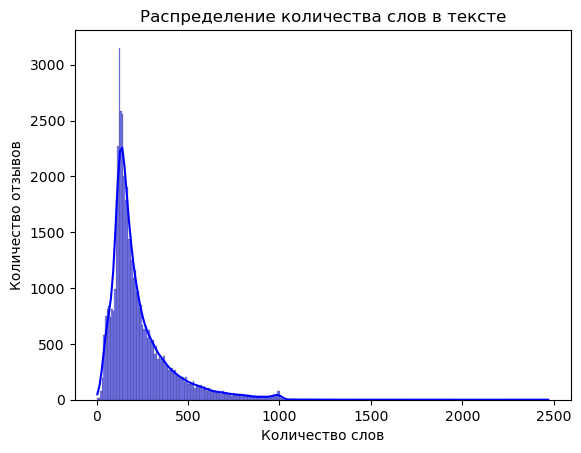

In [18]:
sns.histplot(df['text'].apply(lambda x: len(str(x).split())), kde=True, color='blue')
plt.title('Распределение количества слов в тексте')
plt.xlabel('Количество слов')
plt.ylabel('Количество отзывов')
plt.show()

In [20]:
percentile_99 = df['word_count'].quantile(0.99)
print(f"99%-ный перцентиль: {percentile_99}")

99%-ный перцентиль: 908.0


In [22]:
df = df[df['word_count'] <= percentile_99]

print(f"Количество строк после обрезки: {len(df)}")

Количество строк после обрезки: 49090


In [24]:
# Пример положительных и отрицательных отзывов
positive_sample = df[df['target'] == 1]['text'].iloc[0]
negative_sample = df[df['target'] == 0]['text'].iloc[0]

print("\nПример положительного отзыва:")
print(positive_sample)

print("\nПример отрицательного отзыва:")

print(negative_sample)


Пример положительного отзыва:
I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

Пример отрицательного отзыва:
Once again Mr. Costner has dragged out a movie for far longer than necessary. Aside from the terrific sea rescue sequences, of which there are 

### Пробуем разные сентиментальные готовые словари

In [23]:
df_dict = df.copy()

In [25]:
X_train_dict, X_test_dict, y_train_dict, y_test_dict = train_test_split(df_dict['text'], df_dict['target'], test_size=0.2, random_state=42, stratify=df_dict['target'])
print(f"Размер обучающей выборки: {len(X_train_dict)}")
print(f"Размер тестовой выборки: {len(X_test_dict)}")

Размер обучающей выборки: 39604
Размер тестовой выборки: 9902


In [31]:
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    scores = analyzer.polarity_scores(text)
    return 1 if scores['compound'] > 0 else 0  

y_train_pred = X_train_dict.apply(analyze_sentiment)
y_test_pred = X_test_dict.apply(analyze_sentiment)

train_accuracy = accuracy_score(y_train_dict, y_train_pred)
test_accuracy = accuracy_score(y_test_dict, y_test_pred)

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

Точность на обучающей выборке: 0.6956
Точность на тестовой выборке: 0.6967


In [29]:
def get_sentiment(text):
    blob = TextBlob(text)
    return 1 if blob.sentiment.polarity > 0 else 0

# Применяем функцию к обучающим и тестовым данным
y_train_pred = [get_sentiment(text) for text in X_train_dict]
y_test_pred = [get_sentiment(text) for text in X_test_dict]

# Оценка точности на обучающей и тестовой выборке
train_accuracy = accuracy_score(y_train_dict, y_train_pred)
test_accuracy = accuracy_score(y_test_dict, y_test_pred)

print(f"Точность на обучающей выборке: {train_accuracy:.4f}")
print(f"Точность на тестовой выборке: {test_accuracy:.4f}")

Точность на обучающей выборке: 0.6884
Точность на тестовой выборке: 0.6902


### Подготовка данных и обучение модели машинного обучения

In [26]:
df_machine = df.copy()

In [28]:
# Убираем все неалфавитные символы 
df_machine['text'] = df_machine['text'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x))

In [29]:
# Лишние пробелы
df_machine['cleaned_text'] = df_machine['text'].apply(lambda x: re.sub(r'\s+', ' ', x).strip())

In [41]:
# Лемматизация

# Загрузка списка стоп-слов
stop_words = set(stopwords.words('english'))

# Инициализация лемматизатора
lemmatizer = WordNetLemmatizer()

# Функция для предобработки текста 
def preprocess_text(text):
    # Токенизация
    words = word_tokenize(text.lower())  # Приведение к нижнему регистру
    # Лемматизация и удаление стоп-слов
    words = [lemmatizer.lemmatize(word) for word in words if word.isalnum() and word not in stop_words]
    return ' '.join(words)

# Применим функцию к столбцу текста
df_machine['cleaned_text'] = df_machine['text'].apply(preprocess_text)

In [43]:
df_machine['cleaned_text'].head()

0    went saw movie last night coaxed friend mine i...
1    actor turned director bill paxton follows prom...
2    recreational golfer knowledge sport history pl...
3    saw film sneak preview delightful cinematograp...
4    bill paxton taken true story u golf open made ...
Name: cleaned_text, dtype: object

In [46]:
X_train, X_test, y_train, y_test = train_test_split(df_machine['cleaned_text'], df_machine['target'], test_size=0.2, random_state=42, stratify=df_machine['target'])
print(f"Размер обучающей выборки: {len(X_train)}")
print(f"Размер тестовой выборки: {len(X_test)}")

Размер обучающей выборки: 39604
Размер тестовой выборки: 9902


### TFIDF и Catboost

In [96]:
vectorizer = TfidfVectorizer(min_df=5, max_df=0.9)

X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

print(f"Размер матрицы: {X_train_tfidf.shape}")

Размер матрицы: (39272, 32244)


In [100]:
model = CatBoostClassifier(iterations=800, 
                           learning_rate=0.05, 
                           depth=4, 
                           verbose=200)

model.fit(X_train_tfidf, y_train)

y_pred = model.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

0:	learn: 0.6809346	total: 177ms	remaining: 2m 21s
200:	learn: 0.4285901	total: 30.8s	remaining: 1m 31s
400:	learn: 0.3716128	total: 1m	remaining: 1m
600:	learn: 0.3373877	total: 1m 32s	remaining: 30.7s
799:	learn: 0.3131560	total: 2m	remaining: 0us
Accuracy: 0.8644
F1-Score: 0.8686


In [102]:
y_pred = model.predict(X_train_tfidf)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8825


### Word2Vec и Catboost

In [128]:
X_train_tokens = [text.split() for text in X_train] 

model_w2v = Word2Vec(sentences=X_train_tokens, vector_size=200, window=10, min_count=5, workers=4)

def vectorize_text(text, model, vector_size=100):
    words = text.split()
    word_vectors = []
    for word in words:
        if word in model.wv:
            word_vectors.append(model.wv[word])
    
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size) 

X_train_w2v = np.array([vectorize_text(text, model_w2v) for text in X_train])

X_test_w2v = np.array([vectorize_text(text, model_w2v) for text in X_test])

print(X_train_w2v.shape)
print(X_test_w2v.shape)

(39272, 200)
(9818, 200)


In [138]:
model = CatBoostClassifier(iterations=800, 
                           learning_rate=0.05, 
                           depth=4, 
                           verbose=200)


model.fit(X_train_w2v, y_train)

y_pred = model.predict(X_test_w2v)

accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

0:	learn: 0.6713397	total: 15.9ms	remaining: 12.7s
200:	learn: 0.3405466	total: 2.83s	remaining: 8.42s
400:	learn: 0.3120760	total: 5.6s	remaining: 5.57s
600:	learn: 0.2931892	total: 8.32s	remaining: 2.75s
799:	learn: 0.2778155	total: 11.1s	remaining: 0us
Accuracy: 0.8617
F1-Score: 0.8633


In [139]:
y_pred = model.predict(X_train_w2v)
accuracy = accuracy_score(y_train, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8866


### Bert

In [32]:
model_name = "bert-base-uncased"  
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
train_data, val_data = train_test_split(df, test_size=0.1, random_state=42)

In [36]:
from torch.utils.data import Dataset 
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx], 
            padding='max_length', 
            truncation=True, 
            max_length=self.max_length, 
            return_tensors='pt'
        )
        item = {key: encoding[key].squeeze(0) for key in encoding}
        item['label'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [38]:
train_dataset = TextDataset(train_data['text'].tolist(), train_data['target'].tolist(), tokenizer)
val_dataset = TextDataset(val_data['text'].tolist(), val_data['target'].tolist(), tokenizer)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  
    save_strategy="epoch", 
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    processing_class=tokenizer,
)

In [40]:
# Обучение модели
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.237300,0.188358


TrainOutput(global_step=2762, training_loss=0.21660777795884506, metrics={'train_runtime': 2538.2914, 'train_samples_per_second': 17.406, 'train_steps_per_second': 1.088, 'total_flos': 1.162450953686016e+16, 'train_loss': 0.21660777795884506, 'epoch': 1.0})

In [61]:
checkpoint_dir = './results/checkpoint-2762'

model = BertForSequenceClassification.from_pretrained(checkpoint_dir)
tokenizer = BertTokenizer.from_pretrained(checkpoint_dir)

In [63]:
device = 'cuda'

model.to(device)
model.eval()

all_predictions = []
all_true_labels = []

val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)


with torch.no_grad(): 
    for batch in val_dataloader:
        inputs = {key: batch[key].to(device) for key in batch if key != 'label'}  
        labels = batch['label'].to(device) 

        outputs = model(**inputs, labels=labels)  
        
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1) 
        
        all_predictions.extend(predicted_labels.cpu().numpy()) 
        all_true_labels.extend(labels.cpu().numpy())  

accuracy = accuracy_score(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9556


In [65]:
all_predictions = []
all_true_labels = []

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False)


with torch.no_grad():  
    for batch in train_dataloader:

        inputs = {key: batch[key].to(device) for key in batch if key != 'label'} 
        labels = batch['label'].to(device) 
        

        outputs = model(**inputs, labels=labels)
        
        logits = outputs.logits
        predicted_labels = torch.argmax(logits, dim=1)  
        
        all_predictions.extend(predicted_labels.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy()) 

accuracy = accuracy_score(all_true_labels, all_predictions)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.9544
